In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch import nn



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:

#Create the data loader
class DataLoader(Dataset):
    def __init__(self, img_dir, img_dir2, transform = None, target_transform=None):
        self.img_dir = img_dir
        self.img_dir2 = img_dir2
        self.transform = transform
        self.fileNames = os.listdir(img_dir)
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        label = self.fileNames[idx].rsplit("t-mask-", 1 )[1]
        img_path = os.path.join(self.img_dir, self.fileNames[idx])
        img_path2 = os.path.join(self.img_dir2, label)
        image = read_image(img_path)
        image2 = read_image(img_path2)
        image = torch.tensor(image).float()
        image2 = torch.tensor(image2).float()
        if self.transform:
            image = self.transform(image)
            image2 = self.transform(image2)
        return image, image2

In [3]:
transformer=transforms.Compose([ transforms.Normalize((0, 0, 0), (1, 1, 1)) ])

In [4]:
# Set up the data 
# load dataloader
dataset = DataLoader("Data_small/50_with_mask", "Data_small/50_without_mask",transform = transformer) 
# split the dataset
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
test_train_split = [test_size, train_size]
test, traindata = torch.utils.data.random_split(dataset = dataset, lengths = test_train_split)

# Set up dataloader
batch_size = 25
trainloader = torch.utils.data.DataLoader(traindata, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)
testloader = torch.utils.data.DataLoader(test, 
                                          batch_size=2, 
                                          shuffle=True, 
                                          num_workers=0)
dataiter = iter(trainloader)


In [5]:
bottleneck_size = 25


class VAE(nn.Module):
    def __init__(self):
        
        super(VAE, self).__init__()
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(12**3,1500)
        self.linear2 = nn.Linear(1500,1200)

        
        self.unflatten = nn.Unflatten(dim =1, unflattened_size = (12,10,10))
        
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 44, 3, padding=1)
        self.conv4 = nn.Conv2d(44, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv6 = nn.Conv2d(16, 12, 3, padding=1)
        self.conv7 = nn.Conv2d(16, 12, 3, padding=1)

       
        self.pool = nn.MaxPool2d(2, 2)
        
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(12, 16, 3, stride=3, padding= 2)
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 3, stride=2, padding = 2)
        self.t_conv3 = nn.ConvTranspose2d(32, 16 , 3, stride=1, padding = 1)
        self.t_conv4 = nn.ConvTranspose2d(16, 8, 2, stride=1)
        self.t_conv5 = nn.ConvTranspose2d(8, 3, 3, stride=1, padding = 1)
        
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        mu = self.conv6(x)
        log_sigma = self.conv7(x)
        return mu, log_sigma

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    
    def flatlayer(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return F.relu(x)
    
    def decode(self, x):
        x = self.unflatten(x)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = F.relu(self.t_conv5(x))
        return x
        
        
    def forward(self, x):
        mu, log_sigma = self.encode(x)
        mu = self.flatlayer(mu)
        log_sigma = self.flatlayer(log_sigma)
        z = self.reparameterize(mu, log_sigma)
        x = self.decode(z)      
        return x, mu, log_sigma


   

In [12]:
vae = VAE()

In [13]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vae.to(device)

VAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1728, out_features=1500, bias=True)
  (linear2): Linear(in_features=1500, out_features=1200, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(12, 10, 10))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(44, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(12, 16, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
  (t_conv2): ConvTranspose2d(16, 32, ke

In [15]:
def loss_function(recon_x, x, mu, z_log_sigma):
    loss = nn.MSELoss()
    l = loss(recon_x, x)
    KLD =  torch.sum( z_log_sigma.exp() + mu.pow(2) - z_log_sigma   - 1) #definition fra slides
    #KLD *= 5
    
    return l + KLD

In [16]:
def train(epoch):
    vae.train()
    
    i = 0
    for data in trainloader:
        i += 1
        
        mask_image, image = data    
        optimizer.zero_grad()
        mask_image , image = mask_image.to(device), image.to(device)
        recon_batch, mu, log_sigma = vae(mask_image)
        
        loss = loss_function(recon_batch, image, mu, log_sigma)
        
        loss.backward()
        optimizer.step()
        if i % 60 == 0:
            print("Epoch", epoch, "  Loss: ", loss.item() / len(trainloader))

In [17]:
for epoch in range(1, 20):
    train(epoch)

Epoch 1   Loss:  27.650326538085938
Epoch 1   Loss:  11.790724182128907
Epoch 1   Loss:  11.394485473632812
Epoch 1   Loss:  10.938352966308594
Epoch 1   Loss:  9.736155700683593
Epoch 2   Loss:  11.792096710205078
Epoch 2   Loss:  10.078125762939454
Epoch 2   Loss:  9.922389221191406
Epoch 2   Loss:  9.30255126953125
Epoch 2   Loss:  10.611493682861328
Epoch 3   Loss:  10.022913360595703
Epoch 3   Loss:  9.398201751708985
Epoch 3   Loss:  10.488031005859375
Epoch 3   Loss:  10.371340942382812
Epoch 3   Loss:  9.203229522705078
Epoch 4   Loss:  8.756415557861327
Epoch 4   Loss:  11.231946563720703
Epoch 4   Loss:  10.068511199951171
Epoch 4   Loss:  10.399974060058593
Epoch 4   Loss:  10.026555633544922
Epoch 5   Loss:  10.474041748046876
Epoch 5   Loss:  9.88537368774414
Epoch 5   Loss:  10.027281188964844
Epoch 5   Loss:  8.821106719970704
Epoch 5   Loss:  8.9795166015625
Epoch 6   Loss:  9.785758209228515
Epoch 6   Loss:  9.633835601806641
Epoch 6   Loss:  9.851482391357422
Epoch 6 

In [18]:
def print_image(image, model, correct_image):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint8'))
    ax2.imshow(np.transpose(correct_image.numpy(), (1, 2, 0)).astype('uint8'))
    image = torch.unsqueeze(image,0)
    image = torch.tensor(image).float()
    image = image.to(device)
    output = model(image)[0]
    output = torch.squeeze(output,0)
    if device.type == 'cuda':
        output = torch.Tensor.cpu(output).detach().numpy()
    else:
        output = output.detach().numpy()
        

    ax3.imshow(np.transpose(output, (1, 2, 0)).astype('uint8'))
    plt.show()

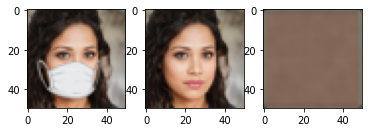

In [23]:
dataiter = iter(testloader)


images, images2 = dataiter.next()
print_image(images[0], model = vae, correct_image = images2[0])